In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#importing libraries
import numpy as np
import pandas as pd
import os
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
import nltk
import re

In [3]:
train = pd.read_csv('/content/drive/MyDrive/reddit/train (1).csv')

In [4]:
train.head()

,Title,Post,Flair
0,netflix the family has been an amazing watch d...,netflixs new series the family is about a secr...,10
1,all results are out is iiitm gwalior it branch...,the internet seems to think so average package...,0
2,which are the things you always buy made in india,you can include the reason for your preference...,0
3,weekly coders hackers amp all tech related thr...,last week issue all threads every week on frid...,11
4,what are some good unknown companies to work a...,there are similar posts on other subreddits bu...,0


In [5]:
train['Flair'].value_counts()

0     16616
7      8118
10     4847
14     1517
9      1046
12      961
1       811
3       793
11      580
4       365
6       293
13      256
5       172
8        96
2        76
Name: Flair, dtype: int64

In [6]:
train['Flair'].max()

14

EDA


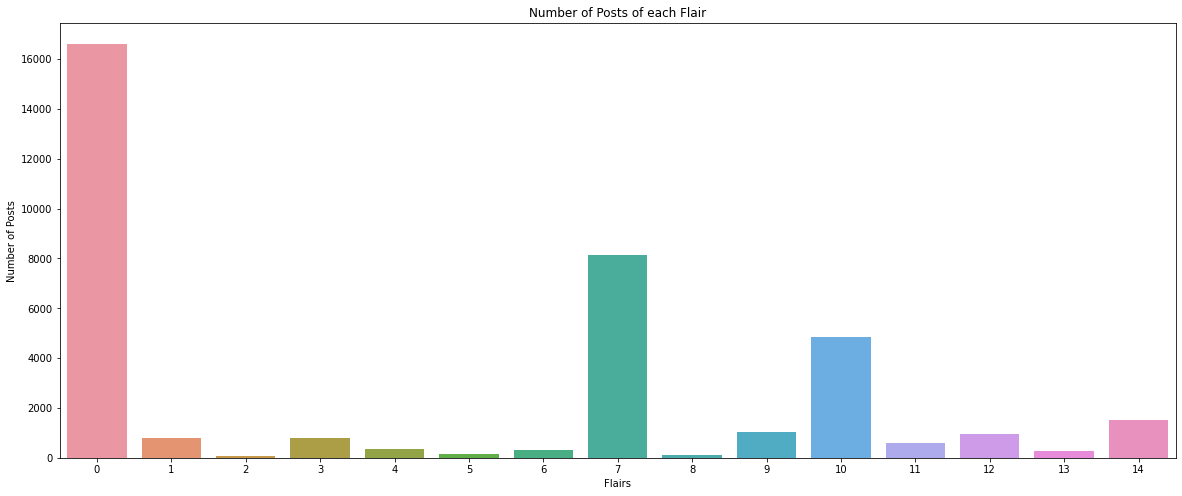

In [7]:
plt.figure(figsize=(20,8))
sns.countplot(x = 'Flair', data=train)
plt.title("Number of Posts of each Flair")
plt.xlabel('Flairs')
plt.ylabel("Number of Posts")
plt.show()

In [8]:
import re
from nltk.corpus import stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
from gensim.models import Word2Vec

In [10]:
val = pd.read_csv('/content/drive/MyDrive/reddit/val (1).csv')

label_to_id={"AskIndia": 0, "Business/Finance": 1, "CAA-NRC": 2, "Coronavirus": 3, "Demonetization": 4, "Entertainment": 5, "Food": 6, "Non-Political": 7, "Photography": 8, "Policy/Economy": 9, "Politics": 10, "Scheduled": 11, "Science/Technology": 12, "Sports": 13, "[R]eddiquette": 14}
id_to_label={v: k for k, v in label_to_id.items()}
id_to_label


{0: 'AskIndia',
 1: 'Business/Finance',
 2: 'CAA-NRC',
 3: 'Coronavirus',
 4: 'Demonetization',
 5: 'Entertainment',
 6: 'Food',
 7: 'Non-Political',
 8: 'Photography',
 9: 'Policy/Economy',
 10: 'Politics',
 11: 'Scheduled',
 12: 'Science/Technology',
 13: 'Sports',
 14: '[R]eddiquette'}

In [11]:
flairs=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
#flairs = [‘AskIndia’, ‘Business/Finance’, ‘CAA-NRC’, ‘Coronavirus’, ‘Demonetization’, ‘Entertainment’, ‘Food’, ‘Non-Political’, ‘Photography’, ‘Policy/Economy’, ‘Politics’, ‘Scheduled’, ‘Science/Technology’, ‘Sports’, ‘[R]eddiquette’]

In [12]:
for flair in id_to_label:
    print (flair,': ' , len(train[train['Flair'] == flair]))

0 :  16616
1 :  811
2 :  76
3 :  793
4 :  365
5 :  172
6 :  293
7 :  8118
8 :  96
9 :  1046
10 :  4847
11 :  580
12 :  961
13 :  256
14 :  1517


In [13]:
for flair in flairs:
    print (flair,': ' , len(val[val['Flair'] == flair]))

0 :  4092
1 :  200
2 :  19
3 :  196
4 :  90
5 :  42
6 :  72
7 :  1999
8 :  24
9 :  257
10 :  1194
11 :  143
12 :  236
13 :  63
14 :  374


In [14]:
#removing nan values
empties = ['nan', '[deleted]', '[removed]']
for empty in empties:
  print(empty, len(train[train['Post'] == empty]))

train['Post'] = train['Post'].apply(lambda x: '' if x in empties else x)
val['Post'] = val['Post'].apply(lambda x: '' if x in empties else x)

empties = ['nan', '[deleted]', '[removed]']
for empty in empties:
  print(empty, len(train[train['Post'] == empty]))

nan 0
[deleted] 0
[removed] 0
nan 0
[deleted] 0
[removed] 0


In [15]:
#merging title and post as they convey the same thing
train['Title'] = train['Title'] + ' ' + train['Post']
val['Title'] = val['Title'] + ' ' + val['Post']

In [16]:
#removing extra characters, stopwords and lemmatizaing 
nltk.download('wordnet')
stop = set(stopwords.words('english'))
def remove_noise(text):

    # Step1: Make lowercase
    text = text.apply(lambda x: " ".join(x.lower() for x in str(x).split()))
    
    # Step2: Remove whitespaces
    text = text.apply(lambda x: " ".join(x.strip() for x in str(x).split()))

    # Step3 : Removing words inside brackets like "[OC]"
    text = text.apply(lambda x: re.sub(r"\[.*?\]", "", x))

    # Step4 : Removing everything from the data which is not alphanumeric.
    text = text.apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))

    # Step5 : Lemmatization
    lm=WordNetLemmatizer()
    text = text.apply(lambda x: lm.lemmatize(x))
    
    # Step6 : Removing Stopwords
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))

    # Convert to string
    text = text.astype(str)
        
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [17]:
train['Title'] = remove_noise(train['Title'])
val['Title'] = remove_noise(val['Title'])

In [18]:
#tokenizing texts 
tokenizer = Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(train['Title'].values)
tokenizer.fit_on_texts(val['Title'].values)

In [19]:

sequences = tokenizer.texts_to_sequences(train['Title'].values)
sequences_val = tokenizer.texts_to_sequences(val['Title'].values)

In [20]:
# model = Word2Vec(str(sequences), min_count=2)

In [21]:
MAX_LEN = 50
padded_sequences = pad_sequences(sequences, padding='pre',maxlen=MAX_LEN)
padded_sequences_val = pad_sequences(sequences_val,padding='pre',maxlen=MAX_LEN)

In [22]:
# #building a model
voc_size = 1000000
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Flatten
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=MAX_LEN))
model.add(LSTM(100))
model.add(Dense(15,activation='sigmoid'))
model.add(Flatten())
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())
import keras.layers as L
from keras.models import Model
from keras.optimizers import Adam


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 40)            40000000  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 15)                1515      
_________________________________________________________________
flatten (Flatten)            (None, 15)                0         
Total params: 40,057,915
Trainable params: 40,057,915
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
#x_train and y_train
y = train['Flair']
X_final=np.array(padded_sequences)
y_final=np.array(y)


In [24]:
print(X_final.shape, y.shape)

(36547, 50) (36547,)


In [25]:
#X_test and y_test
y_val = val['Flair']
X_final_val = np.array(padded_sequences_val)
y_final_val = np.array(y_val)


In [26]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 40)            40000000  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 15)                1515      
_________________________________________________________________
flatten (Flatten)            (None, 15)                0         
Total params: 40,057,915
Trainable params: 40,057,915
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(X_final,y_final,batch_size=1000,epochs=10,verbose=1,shuffle=True,validation_data=(X_final_val, y_final_val))

Epoch 1/10
37/37 [==============================] - 42s 1s/step - loss: 2.1525 - accuracy: 0.4424 - val_loss: 1.7401 - val_accuracy: 0.4546
Epoch 2/10
37/37 [==============================] - 39s 1s/step - loss: 1.7113 - accuracy: 0.4546 - val_loss: 1.6987 - val_accuracy: 0.4546
Epoch 3/10
37/37 [==============================] - 40s 1s/step - loss: 1.6954 - accuracy: 0.4546 - val_loss: 1.6938 - val_accuracy: 0.4546
Epoch 4/10
37/37 [==============================] - 39s 1s/step - loss: 1.6875 - accuracy: 0.4546 - val_loss: 1.6859 - val_accuracy: 0.4546
Epoch 5/10
37/37 [==============================] - 39s 1s/step - loss: 1.6611 - accuracy: 0.4546 - val_loss: 1.6509 - val_accuracy: 0.4546
Epoch 6/10
37/37 [==============================] - 39s 1s/step - loss: 1.5728 - accuracy: 0.4546 - val_loss: 1.5678 - val_accuracy: 0.4546
Epoch 7/10
37/37 [==============================] - 39s 1s/step - loss: 1.4830 - accuracy: 0.4547 - val_loss: 1.5401 - val_accuracy: 0.4555
Epoch 8/10
37/37 [==

Epoch 1/10
37/37 [==============================] - 39s 1s/step - loss: 1.0799 - accuracy: 0.6520 - val_loss: 1.5436 - val_accuracy: 0.5202
Epoch 2/10
37/37 [==============================] - 39s 1s/step - loss: 0.9695 - accuracy: 0.6958 - val_loss: 1.5903 - val_accuracy: 0.5083
Epoch 3/10
37/37 [==============================] - 38s 1s/step - loss: 0.8719 - accuracy: 0.7373 - val_loss: 1.6690 - val_accuracy: 0.5093
Epoch 4/10
37/37 [==============================] - 38s 1s/step - loss: 0.7730 - accuracy: 0.7745 - val_loss: 1.7003 - val_accuracy: 0.4956
Epoch 5/10
37/37 [==============================] - 38s 1s/step - loss: 0.6930 - accuracy: 0.8013 - val_loss: 1.7948 - val_accuracy: 0.4872
Epoch 6/10
37/37 [==============================] - 38s 1s/step - loss: 0.6181 - accuracy: 0.8249 - val_loss: 1.8654 - val_accuracy: 0.4943
Epoch 7/10
37/37 [==============================] - 39s 1s/step - loss: 0.5545 - accuracy: 0.8483 - val_loss: 1.9417 - val_accuracy: 0.4801
Epoch 8/10
37/37 [==

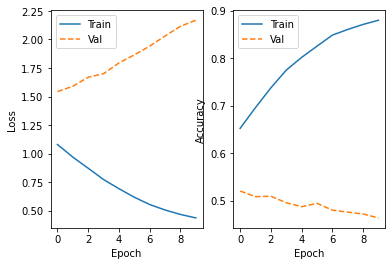

In [30]:
#accuracy of 53.11 using unidirectional LSTM and embedding layer
BATCH_SIZE = 1000
EPOCHS = 10
history = model.fit(X_final,y_final,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_final_val, y_final_val))
def plot_metrics(history):



    metrics = [
        "loss",


        "accuracy"
        
        
    ]

    for n, metric in  enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(1, 2, n + 1)
        plt.plot(
            history.epoch,
            history.history[metric],
            # color=colors[0],
            label="Train",
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            # color=colors[1],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        plt.legend()
plot_metrics(history)